# Calculate damages

Finally, we use the extracted flood and network data to perform an expected annual damages calculation

In [1]:
import os
import re
from glob import glob
from pathlib import Path

import geopandas as gpd
import pandas as pd
from pyproj import Geod
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import rasterio
import snail
import snail.damages
import snail.io
from scipy.integrate import simpson, cumulative_trapezoid

from utils import aqueduct_rp

In [2]:
data_dir = "data"
country_iso = "bgd"

In [3]:
# flood hazard data to use, pulled from the autopkg API
epoch = 2050
scenario = "rcp4p5"
raster_paths = glob(f"data/{country_iso}/wri_aqueduct*/*{scenario}_wtsub_{epoch}*.tif")
raster_paths = sorted(raster_paths, key=aqueduct_rp, reverse=True)

(network_file,) = glob(f"data/{country_iso}/gri_osm*/*.gpkg")
network = gpd.read_file(network_file)

In [4]:
raster_paths_df = pd.DataFrame({"path": raster_paths})
raster_paths_df["key"] = [Path(path).stem for path in raster_paths]
raster_paths_df, grids = snail.io.extend_rasters_metadata(raster_paths_df)

# Check that all the grid definitions are consistent
if len(grids) != 1:
    print("ERROR: Expected all raster files to be on a consistent grid")
    grid_0 = grids[0]
    for n, grid in enumerate(grids[1:]):
        print(
            f"Grid {n}\n"
            f"    Height: expected={grid_0.height}; actual={grid.height}\n"
            f"    Width: expected={grid_0.width}; actual={grid.width}\n"
            f"    Transform: expected={grid_0.transform}; actual={grid.transform}"
        )
else:
    grid = grids[0]
raster_paths_df

,path,key,grid_id,bands
0,data/bgd/wri_aqueduct_version_2/wri_aqueduct-v...,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_...,0,"(1,)"
1,data/bgd/wri_aqueduct_version_2/wri_aqueduct-v...,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_...,0,"(1,)"
2,data/bgd/wri_aqueduct_version_2/wri_aqueduct-v...,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_...,0,"(1,)"
3,data/bgd/wri_aqueduct_version_2/wri_aqueduct-v...,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_...,0,"(1,)"
4,data/bgd/wri_aqueduct_version_2/wri_aqueduct-v...,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_...,0,"(1,)"
5,data/bgd/wri_aqueduct_version_2/wri_aqueduct-v...,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_...,0,"(1,)"
6,data/bgd/wri_aqueduct_version_2/wri_aqueduct-v...,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_...,0,"(1,)"
7,data/bgd/wri_aqueduct_version_2/wri_aqueduct-v...,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_...,0,"(1,)"
8,data/bgd/wri_aqueduct_version_2/wri_aqueduct-v...,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_...,0,"(1,)"
9,data/bgd/wri_aqueduct_version_2/wri_aqueduct-v...,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_...,0,"(1,)"


In [5]:
# filter network to linestrings only (edges)
lines = network[network.geometry.type == "LineString"]

# filter to roads
desired_layers = {"motorway", "primary", "secondary", "tertiary", "trunk"}
lines = lines[lines.asset_type.isin(desired_layers)]

# split edges on raster grid
prepared = snail.intersection.prepare_linestrings(lines)
splits = snail.intersection.split_linestrings(prepared, grid)

# calculate split edge lengths
geod = Geod(ellps="WGS84")
meters_per_km = 1_000
splits["length_km"] = splits.geometry.apply(geod.geometry_length) / meters_per_km

# which cell is each split edge in?
splits_with_raster_indices = snail.intersection.apply_indices(
    splits, grid, index_i="i_0", index_j="j_0"
)

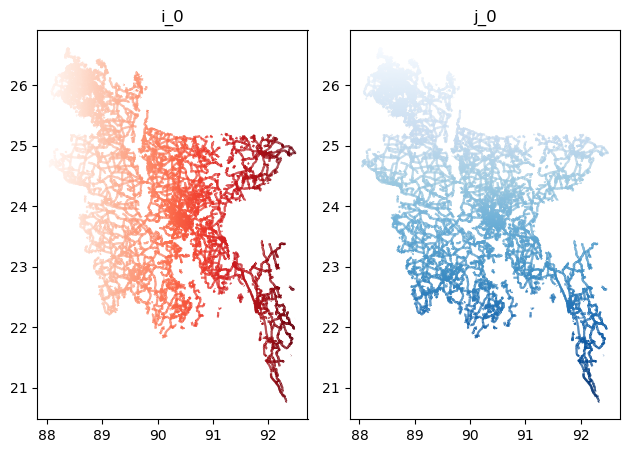

In [6]:
# map raster indices as visual check
f, (ax_i, ax_j) = plt.subplots(ncols=2)

ax_i = splits_with_raster_indices.plot(ax=ax_i, column="i_0", cmap="Reds")
ax_i.set_title("i_0")

splits_with_raster_indices.plot(ax=ax_j, column="j_0", cmap="Blues")
ax_j.set_title("j_0")
f.tight_layout()

In [7]:
hazard_intensities = snail.io.associate_raster_files(
    splits_with_raster_indices, raster_paths_df
)
hazard_intensities.describe()

,asset_id,paved,lanes,rehab_cost_USD_per_km,bridge,split,length_km,i_0,j_0,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp1000_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0500_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0250_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0100_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0050_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0025_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0010_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0005_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0002_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0001_5-bgd
count,8.742700e+04,87427.000000,87427.000000,8.742700e+04,0.0,87427.000000,8.742700e+04,87427.000000,87427.000000,87427.000000,87427.000000,87427.000000,87427.000000,87427.000000,87427.000000,87427.000000,87427.000000,87427.000000,87427.000000
mean,2.016608e+07,0.366614,1.345625,3.975468e+06,NaN,2.210381,4.121282e-01,235.542578,289.748442,-1.412627,-1.513538,-1.604113,-1.711449,-1.791167,-1.850480,-1.915746,-1.960237,-1.999641,-2.004947
std,2.428514e+05,0.481883,0.573187,1.472179e+07,NaN,3.690326,3.475057e-01,130.494337,146.997210,143.476120,143.473129,143.470520,143.467529,143.465469,143.463913,143.462280,143.461212,143.460312,143.460190
min,1.982070e+07,0.000000,1.000000,2.354510e+04,NaN,0.000000,1.437948e-12,4.000000,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
25%,1.993253e+07,0.000000,1.000000,2.354510e+04,NaN,0.000000,9.734774e-02,118.000000,182.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000920e+07,0.000000,1.000000,2.354510e+04,NaN,1.000000,3.143407e-01,236.000000,295.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.040790e+07,1.000000,2.000000,6.965607e+05,NaN,3.000000,7.132925e-01,317.000000,396.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.045315e+07,1.000000,30.000000,2.448349e+08,NaN,52.000000,2.113199e+00,536.000000,702.000000,9.815089,9.341475,8.867518,8.239826,7.763097,7.282821,6.635424,6.054329,5.597771,5.545167


<Axes: xlabel='Hazard Intensity', ylabel='Damage Fraction'>

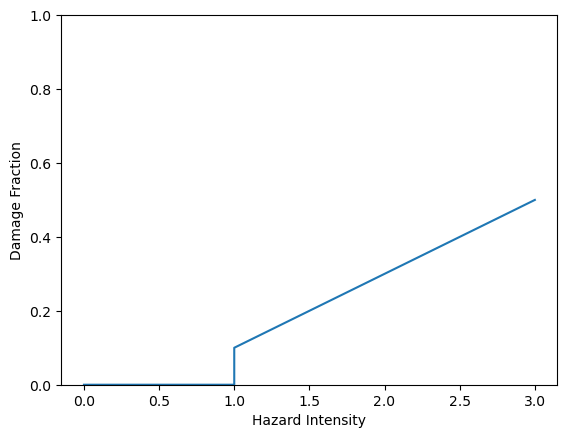

In [8]:
damage_curve = snail.damages.PiecewiseLinearDamageCurve(
    pd.DataFrame(
        {
            "intensity": [0.0, 0.999999999, 1, 2, 3],
            "damage": [0.0, 0.0, 0.1, 0.3, 0.5],
        }
    )
)
damage_curve.plot()

In [9]:
hazard_intensities

,asset_id,osm_way_id,asset_type,paved,material,lanes,_asset_type,rehab_cost_USD_per_km,sector,subsector,...,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp1000_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0500_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0250_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0100_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0050_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0025_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0010_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0005_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0002_0-bgd,wri_aqueduct-version_2-inuncoast_rcp4p5_wtsub_2050_rp0001_5-bgd
0,20432827.0,758400140,secondary,0.0,gravel,1.0,road_bridge,4.080582e+07,transport,road,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,19932902.0,523288381,secondary,0.0,gravel,1.0,road_bridge,4.080582e+07,transport,road,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,20363174.0,162681787,secondary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,20363174.0,162681787,secondary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,20363174.0,162681787,secondary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37077,20452680.0,1099484696,tertiary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,2.01105,1.537436,1.063479,0.435787,0.0,0.0,0.0,0.0,0.0,0.0
37078,20452681.0,1099484697,tertiary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,2.01105,1.537436,1.063479,0.435787,0.0,0.0,0.0,0.0,0.0,0.0
37079,20452682.0,1099484698,tertiary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,2.01105,1.537436,1.063479,0.435787,0.0,0.0,0.0,0.0,0.0,0.0
37080,20453149.0,1102458292,tertiary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# calculate how badly each split edge is damaged by the flooding
damage_fractions = hazard_intensities.rename(columns={
    colname: f"rp-{aqueduct_rp(colname)}"
    for colname in hazard_intensities.columns
    if "wri_aqueduct" in colname
})
hazard_cols = [col for col in damage_fractions.columns if col.startswith("rp-")]
for hazard_col in hazard_cols:
    damage_fractions[hazard_col] = damage_curve.damage_fraction(damage_fractions[hazard_col])
damage_fractions

,asset_id,osm_way_id,asset_type,paved,material,lanes,_asset_type,rehab_cost_USD_per_km,sector,subsector,...,rp-1000,rp-500,rp-250,rp-100,rp-50,rp-25,rp-10,rp-5,rp-2,rp-1
0,20432827.0,758400140,secondary,0.0,gravel,1.0,road_bridge,4.080582e+07,transport,road,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19932902.0,523288381,secondary,0.0,gravel,1.0,road_bridge,4.080582e+07,transport,road,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20363174.0,162681787,secondary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20363174.0,162681787,secondary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20363174.0,162681787,secondary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37077,20452680.0,1099484696,tertiary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,0.30221,0.207487,0.112696,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37078,20452681.0,1099484697,tertiary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,0.30221,0.207487,0.112696,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37079,20452682.0,1099484698,tertiary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,0.30221,0.207487,0.112696,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37080,20453149.0,1102458292,tertiary,0.0,gravel,1.0,road_unpaved,2.354510e+04,transport,road,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# calculate the cost of damage
reconstruction_cost_currency_per_km = 1e5

damage_cost = damage_fractions.copy()
for col in hazard_cols:
    damage_cost[col] = (
        damage_cost[col] * damage_cost.length_km * reconstruction_cost_currency_per_km
    )

grouped_damage_cost = damage_cost[hazard_cols].groupby(damage_cost.asset_id).sum()
probability_per_year = 1 / np.array(
    [int(col.replace("rp-", "")) for col in hazard_cols]
)

damage_probability_curve = grouped_damage_cost.copy()
damage_probability_curve.columns = probability_per_year

Text(0.5, 1.0, 'Damage-probability curve\nRCP4P5 2050')

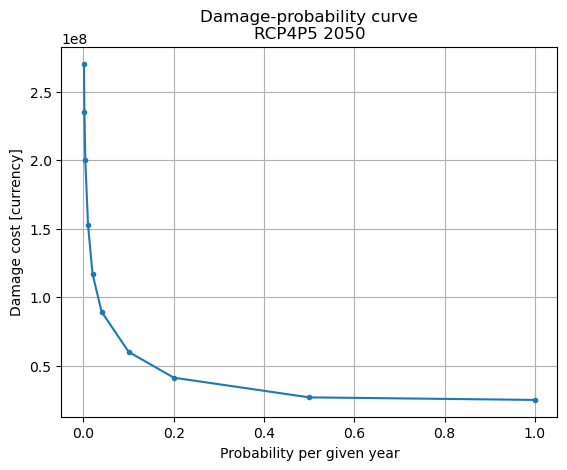

In [12]:
# plot the damage-probability curve
f, ax = plt.subplots()
damage_probability = damage_probability_curve.sum()
ax.plot(damage_probability.index, damage_probability.values, ".", ls="-")
ax.grid()
ax.set_xlabel("Probability per given year")
ax.set_ylabel("Damage cost [currency]")
ax.set_title(f"Damage-probability curve\n{scenario.upper()} {epoch}")

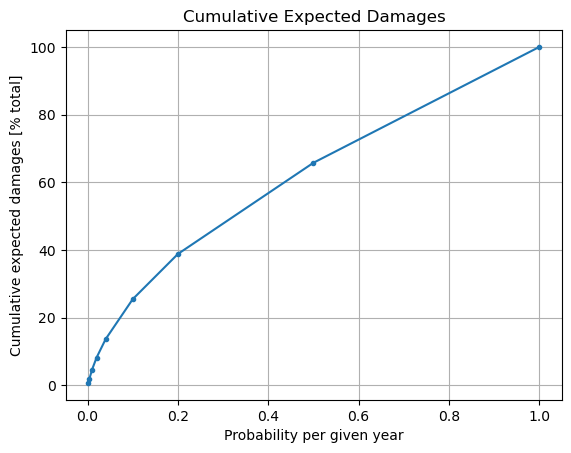

In [13]:
# check how the damage cost cumulatively grows as a function of probability
y = cumulative_trapezoid(grouped_damage_cost.sum(), probability_per_year)
f, ax = plt.subplots()
ax.plot(probability_per_year[1:], 100 * (y / y[-1]), ".", ls="-")
ax.set_xlabel("Probability per given year")
ax.set_ylabel("Cumulative expected damages [% total]")
ax.set_title("Cumulative Expected Damages")
# ax.set_xscale("log")
ax.grid()

# here, the tail risks aren't adding much to the expected annual damage figure

Text(0.5, 1.0, 'Expected Damages [currency per annum]\nTotal: 3.60E+07')

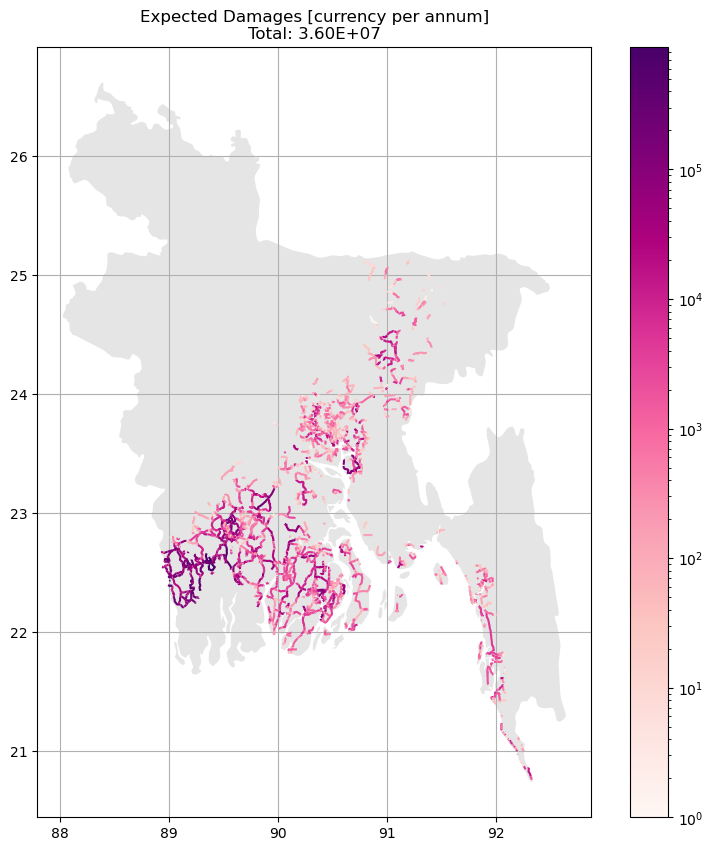

In [14]:
# calculate the expected annual damages for every edge
# that is, integrate the damage-probability curve, for every row
grouped_damage_cost["ead"] = simpson(grouped_damage_cost, x=probability_per_year, axis=1)
EAD = lines.set_index("asset_id")[["geometry"]].copy().join(grouped_damage_cost["ead"])

# map the expected annual damages
f, ax = plt.subplots(figsize=(10, 10))

border = gpd.read_file(os.path.join(data_dir, country_iso, "territory.gpkg"))
border.plot(ax=ax, alpha=0.1, color="black")

EAD.plot(
    ax=ax,
    column="ead",
    legend=True,
    cmap="RdPu",
    norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=EAD.ead.max()),
)
ax.grid()
ax.set_title(f"Expected Damages [currency per annum]\nTotal: {EAD.ead.sum():.2E}")